In [1]:
from dataclasses import asdict

from nerfstudio.cameras.camera_optimizers import CameraOptimizerConfig
from nerfstudio.data.datamanagers.ad_datamanager import ADDataManagerConfig
from nerfstudio.data.dataparsers.pandaset_dataparser import PandaSetDataParserConfig
from nerfstudio.generative.diffusion_model import DiffusionModelConfig, DiffusionModelId, DiffusionModelType
from nerfstudio.models.neurad import NeuRADModel, NeuRADModelConfig
from nerfstudio.pipelines.diffusion_nerf_pipeline import DiffusionNerfConfig


In [2]:
from copy import deepcopy
from typing import Tuple
from nerfstudio.cameras.cameras import Cameras
from nerfstudio.pipelines.diffusion_nerf_pipeline import rotate_around
from torch import Tensor
from PIL import Image


def shift_cameras(cameras: Cameras, pose_offset: Tensor) -> Cameras:
    cameras = deepcopy(cameras)
    device = cameras.device
    aug_translation = pose_offset[..., :3].to(device=device)  # 3
    aug_rotation = pose_offset[..., 3:].to(device=device)  # 3

    c2w = cameras.camera_to_worlds 
    translation = c2w[..., :3] @ aug_translation

    local_rotation = (  # Chain together rotations, X -> Y -> Z
        rotate_around(aug_rotation[2], 2)
        @ rotate_around(aug_rotation[1], 1)
        @ rotate_around(aug_rotation[0], 0)
    ).to(device)
    c2w[:, :3, :3] = local_rotation @ c2w[:, :3, :3]
    c2w[:, :3, 3:4] += translation.reshape(-1, 3, 1)

    cameras.camera_to_worlds = c2w

    return cameras


def prettify_img(img: Tensor, title: str = ""):
    img = img.detach().cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    pil_image = Image.fromarray((img * 255).astype("uint8")) 
    return pil_image

In [5]:
sequence = "001"

pipe = DiffusionNerfConfig(
    max_steps=40001,
    calc_fid_steps=tuple(range(0, 40001, 5000)),
    ray_patch_size=(128, 128),
    datamanager=ADDataManagerConfig(
        dataparser=PandaSetDataParserConfig(add_missing_points=True, cameras=("front",), sequence=sequence),
        train_num_rays_per_batch=16384,
        eval_num_rays_per_batch=16384,
        num_processes=0
    ),
    model=NeuRADModelConfig(
        eval_num_rays_per_chunk=1 << 15,
        camera_optimizer=CameraOptimizerConfig(mode="off"),  # SO3xR3
        rgb_upsample_factor=4,
    ),
    diffusion_model=DiffusionModelConfig(
        dtype="fp16",
    ),
    augment_phase_step=0,
    augment_strategy="none",
).setup(device="cuda")
pipe.eval()


Output()

Output()

Setting up evaluation dataset...

Caching all 40 images.

Output()

Caching all 40 images.

Output()

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


DiffusionNerfPipeline(
  (datamanager): ADDataManager(
    (train_lidar_ray_generator): LidarRayGenerator()
    (train_ray_generator): RayGenerator()
    (eval_ray_generator): RayGenerator()
    (eval_lidar_ray_generator): LidarRayGenerator()
  )
  (_model): NeuRADModel(
    (collider): NearFarCollider()
    (dynamic_actors): DynamicActors()
    (camera_optimizer): CameraOptimizer()
    (field): NeuRADField(
      (hashgrid): NeuRADHashEncoding(
        (actors): DynamicActors()
        (static_contraction): ScaledSceneContraction()
        (actor_contraction): ScaledSceneContraction()
        (static_grid): HashEncoding(
          (tcnn_encoding): Encoding(n_input_dims=3, n_output_dims=32, seed=1337, dtype=torch.float16, hyperparams={'base_resolution': 32, 'hash': 'CoherentPrime', 'interpolation': 'Linear', 'log2_hashmap_size': 22, 'n_features_per_level': 4, 'n_levels': 8, 'otype': 'Grid', 'per_level_scale': 2.208178997039795, 'type': 'Hash'})
        )
        (actor_grids): ModuleLi

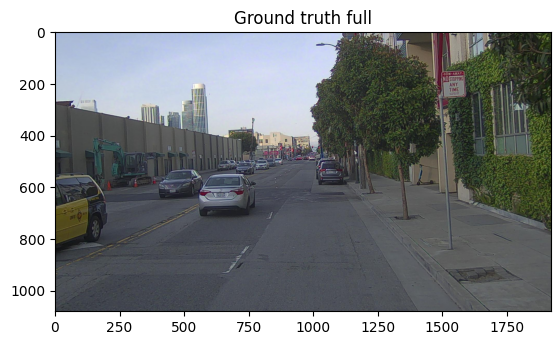

In [ ]:
import math
from nerfstudio.pipelines.diffusion_nerf_pipeline import PoseConfig
import torch
from nerfstudio.generative.utils import show_img
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

mock_path = Path("tests/mock_data/shift_v_unshifted")
full_image_path = mock_path / "full_image"
shift_xs = [0, -2, -4, -6, -8]
rot_zs = [0, 15, 30, 45]

SAVE_MOCK = False
if SAVE_MOCK:
    with torch.no_grad():
        full_image_path.mkdir(exist_ok=True, parents=True)

        camera, batch = pipe.datamanager.next_eval_image(0)

        with open(full_image_path / "camera.pkl", "wb") as f:
            pickle.dump(camera, f)
        with open(full_image_path / "batch.pkl", "wb") as f:
            pickle.dump(batch, f)

        for shift_x in shift_xs:
            for rot_z in rot_zs:
                pose_offset = PoseConfig(pos_x=shift_x, rot_z=rot_z)
                shifted_cameras = shift_cameras(camera, pose_offset.tensor_rad)

                with open(full_image_path / f"camera_{-shift_x}_{rot_z}.pkl", "wb") as f:
                    pickle.dump(shifted_cameras, f)
        
with open(full_image_path / "camera.pkl", "rb") as f:
    camera = pickle.load(f)
with open(full_image_path / "batch.pkl", "rb") as f:
    batch = pickle.load(f)

gt_full = batch["image"]

plt.imshow(gt_full.cpu().numpy())
plt.title("Ground truth full")
plt.show()

def get_cam(pos_x, rot_z) -> Cameras:
    with open(full_image_path / f"camera_{-pos_x}_{rot_z}.pkl", "rb") as f:
        return pickle.load(f)

In [23]:
from PIL import Image
import itertools as it
from pathlib import Path
import torch
import tqdm

models = [
    "base_neurad", "base_diffusion", "un4", "un4cn4", "un128", "un128cn128"
]
steps = {"un4": 40000, "un4cn4": 40000, "un128": 25000, "un128cn128":  "40000"}


GEN_TRAINED_DIFFUSION = True
if GEN_TRAINED_DIFFUSION:
    imgs_dir = Path("experiments/Images")
    experiment_name = "Neurad_Finetuned_Diffusion"
    task_name = "base_vs_finetuned"
    img_subdir = imgs_dir / experiment_name / task_name / sequence
    img_subdir.mkdir(parents=True, exist_ok=True)

    for model in models:
        print(f"Generating images for model {model}...")
        if model == "base_neurad":
            nerf_checkpoint = f"models/diffusionnerf/base-neurad/{sequence}/nerfstudio_models/step-000040000.ckpt"
        elif model == "base_diffusion":
            nerf_checkpoint = f"models/diffusionnerf/base-diffusion/{sequence}/nerfstudio_models/step-000040000.ckpt"
        else:
            nerf_checkpoint = f"models/diffusionnerf/finetuned-diffusion-{model}/{sequence}/nerfstudio_models/step-0000{steps[model]}.ckpt"
        
        pipe = DiffusionNerfConfig(
            max_steps=40001,
            calc_fid_steps=tuple(range(0, 40001, 5000)),
            ray_patch_size=(128, 128),
            nerf_checkpoint=nerf_checkpoint,
            datamanager=ADDataManagerConfig(
                dataparser=PandaSetDataParserConfig(add_missing_points=True, cameras=("front",), sequence=sequence),
                train_num_rays_per_batch=16384,
                eval_num_rays_per_batch=16384,
                num_processes=0
            ),
            model=NeuRADModelConfig(
                eval_num_rays_per_chunk=1 << 15,
                camera_optimizer=CameraOptimizerConfig(mode="off"),  # SO3xR3
                rgb_upsample_factor=4,
            ),
            diffusion_model=DiffusionModelConfig(
                dtype="fp16",
            ),
            augment_phase_step=0,
            augment_strategy="none",
        ).setup(device="cuda")
        pipe.eval()
        dataset = pipe.datamanager.eval_dataset
        
        for img_idx in tqdm.tqdm(range(0, len(dataset), 5), desc="Generating images..."):
            camera = dataset.cameras[img_idx:img_idx+1].to(device="cuda")
            img_gt = dataset.get_image_float32(img_idx).to(device="cuda")
            img_gt = prettify_img(img_gt)
            img_gt.save(img_subdir / f"{img_idx}_gt.png")
            
            for shift_x, rot_z in it.product(shift_xs, rot_zs):
                shifted_cameras = shift_cameras(camera, PoseConfig(pos_x=shift_x, rot_z=rot_z).tensor_rad)
                with torch.no_grad():
                    img_out = pipe.model.get_outputs_for_camera(shifted_cameras)

                img_out_pretty = prettify_img(img_out["rgb"])
                img_out_name = f"{img_idx}_{model}_{-shift_x}_{rot_z}.png"
                img_out_path = img_subdir / img_out_name
                img_out_pretty.save(img_out_path)




Generating images for model base_neurad...


Output()

Output()

Setting up evaluation dataset...

Caching all 40 images.

Output()

Caching all 40 images.

Output()

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Generating images for model base_diffusion...


Output()

Output()

Setting up evaluation dataset...

Caching all 40 images.

Output()

Caching all 40 images.

Output()

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Generating images for model un4...


Output()

Output()

Setting up evaluation dataset...

Caching all 40 images.

Output()

Caching all 40 images.

Output()

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Generating images for model un4cn4...


Output()

Output()

Setting up evaluation dataset...

Caching all 40 images.

Output()

Caching all 40 images.

Output()

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Generating images for model un128...


Output()

Output()

Setting up evaluation dataset...

Caching all 40 images.

Output()

Caching all 40 images.

Output()

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Generating images for model un128cn128...


Output()

Output()

Setting up evaluation dataset...

Caching all 40 images.

Output()

Caching all 40 images.

Output()

/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/gasparyanartur/dev/neurad-studio/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
